In [6]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

# Language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# Language processing with TextBlob
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

from collections import Counter

In [7]:
# Create spark session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [8]:
def spark_to_pandas(spark_metrics):
    metrics_pd = spark_metrics.toPandas()
    metrics_pd = metrics_pd.set_index('creation_date')
    metrics_pd = metrics_pd.sort_index()
    return metrics_pd

In [9]:
def get_metrics(filename, sql_query, sql_table_name):
    spark_metrics = spark.read.load(filename)
    spark_metrics.registerTempTable(sql_table_name)
    avg_metrics = spark.sql(sql_query)

    pd_metrics = spark_to_pandas(spark_metrics)
    pd_metrics_avg = spark_to_pandas(avg_metrics)
    pd_metrics_n = pd_metrics.div(pd_metrics['msg_count'], axis=0)
    pd_metrics_avg_n = pd_metrics_avg.div(pd_metrics_avg['msg_count_60d_avg'], axis=0)
    
    return pd_metrics_n, pd_metrics_avg_n, pd_metrics, pd_metrics_avg

### NLTK Metrics

In [10]:
nltk_full_name = '../data/nlp_nltk_metrics_daily_full_0.01.parquet/'
nltk_15_17_name = '../data/nlp_nltk_metrics_daily_15_17_0.1.parquet/'

nltk_sql_table_name = 'nltk_metrics'
nltk_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nltk_negativity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_negativity_60d_avg,

    AVG(sum_nltk_neutrality) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_neutrality_60d_avg,
    
    AVG(sum_nltk_positivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nltk_positivity_60d_avg

FROM {nltk_sql_table_name}
""")

def plot_nltk_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    # TODO: ADD LEGENDS
    def plot_averages(neg=True, neu=True, pos=True):
        plt.figure(figsize=(20, 10))
        if neg:
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
        if neu:
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
        if pos:
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
    
    # TODO: ADD LEGENDS
    def plot_stat(neg=False, neu=False, pos=False):
        if neg or neu or pos:
            plt.figure(figsize=(20, 10))
        if neg:
            plt.plot(m_n['sum_nltk_negativity'])
            plt.plot(m_avg_n['nltk_negativity_60d_avg'])
        elif neu:
            plt.plot(m_n['sum_nltk_neutrality'])
            plt.plot(m_avg_n['nltk_neutrality_60d_avg'])
        elif pos:
            plt.plot(m_n['sum_nltk_positivity'])
            plt.plot(m_avg_n['nltk_positivity_60d_avg'])
        else:
            print('Please set one of the following parameter to True: [neg, neu, pos]')
            
    return plot_averages, plot_stat

#### NLTK 2005 - 2017

In [11]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)

AnalysisException: 'Path does not exist: file:/Users/cedricviaccoz/Reddit-opinions-polarization/data/nlp_nltk_metrics_daily_full_0.01.parquet;'

In [ ]:
nltk_plot_averages()

In [ ]:
nltk_plot_averages(neu=False)

In [ ]:
nltk_plot_averages(neg=False, pos=False)

In [ ]:
nltk_plot_stat(neg=True)

In [ ]:
nltk_plot_stat(neu=True)

In [ ]:
nltk_plot_stat(pos=True)

#### NLTK 2015 - 2017

In [12]:
nltk_plot_averages, nltk_plot_stat = plot_nltk_metrics(nltk_15_17_name, nltk_sql_query, nltk_sql_table_name)

AnalysisException: 'Path does not exist: file:/Users/cedricviaccoz/Reddit-opinions-polarization/data/nlp_nltk_metrics_daily_15_17_0.1.parquet;'

In [13]:
nltk_plot_averages()

NameError: name 'nltk_plot_averages' is not defined

In [14]:
nltk_plot_averages(neu=False)

NameError: name 'nltk_plot_averages' is not defined

In [15]:
nltk_plot_averages(neg=False, pos=False)

NameError: name 'nltk_plot_averages' is not defined

In [16]:
nltk_plot_stat(neg=True)

NameError: name 'nltk_plot_stat' is not defined

In [17]:
nltk_plot_stat(neu=True)

NameError: name 'nltk_plot_stat' is not defined

In [18]:
nltk_plot_stat(pos=True)

NameError: name 'nltk_plot_stat' is not defined

### TextBlob Metrics

In [19]:
blob_full_name = '../data/nlp_blob_metrics_daily_full_0.01.parquet/'
blob_15_17_name = '../data/nlp_blob_metrics_daily_15_17_0.1.parquet/'

blob_sql_table_name = 'blob_metrics'
blob_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_blob_polarity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_polarity_60d_avg,

    AVG(sum_blob_subjectivity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS text_blob_subjectivity_60d_avg

FROM {blob_sql_table_name}
""")

def plot_blob_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    # TODO: ADD LEGENDS
    def plot_stat(pol=False, pol_avg=False, subj=False, subj_avg=False):
        if pol_avg or pol or subj_avg or subj:
            plt.figure(figsize=(20, 10))
            if pol:
                plt.plot(m_n['sum_blob_polarity'])
            if pol_avg:
                plt.plot(m_avg_n['text_blob_polarity_60d_avg'])
            if subj:
                plt.plot(m_n['sum_blob_subjectivity'])
            if subj_avg:
                plt.plot(m_avg_n['text_blob_subjectivity_60d_avg'])
        else:
            print('Please set one of the following parameter to True: [pol, pol_avg, subj, subj_avg]')
            
    return plot_stat

#### Blob 2005 - 2017

In [20]:
blob_plot_stat = plot_blob_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)

AnalysisException: 'Path does not exist: file:/Users/cedricviaccoz/Reddit-opinions-polarization/data/nlp_blob_metrics_daily_full_0.01.parquet;'

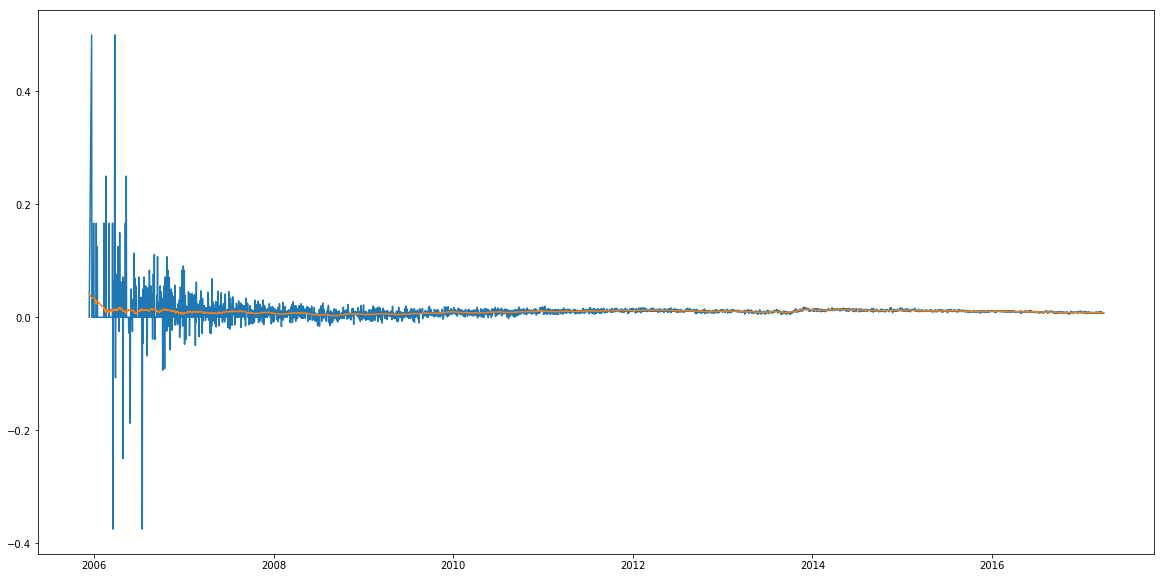

In [105]:
blob_plot_stat(pol=True, pol_avg=True)

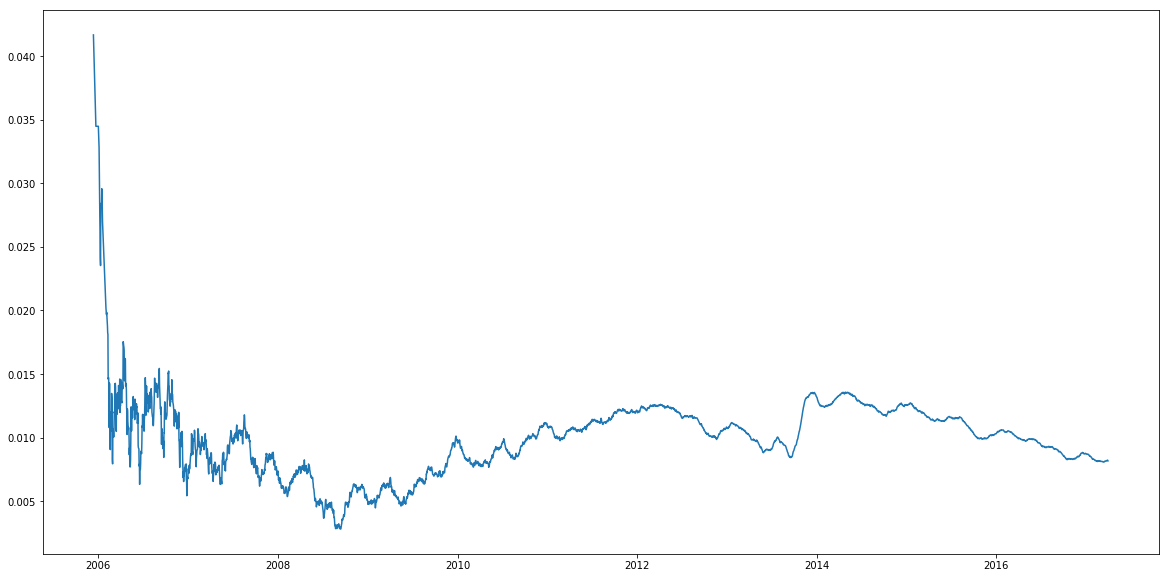

In [102]:
blob_plot_stat(pol_avg=True)

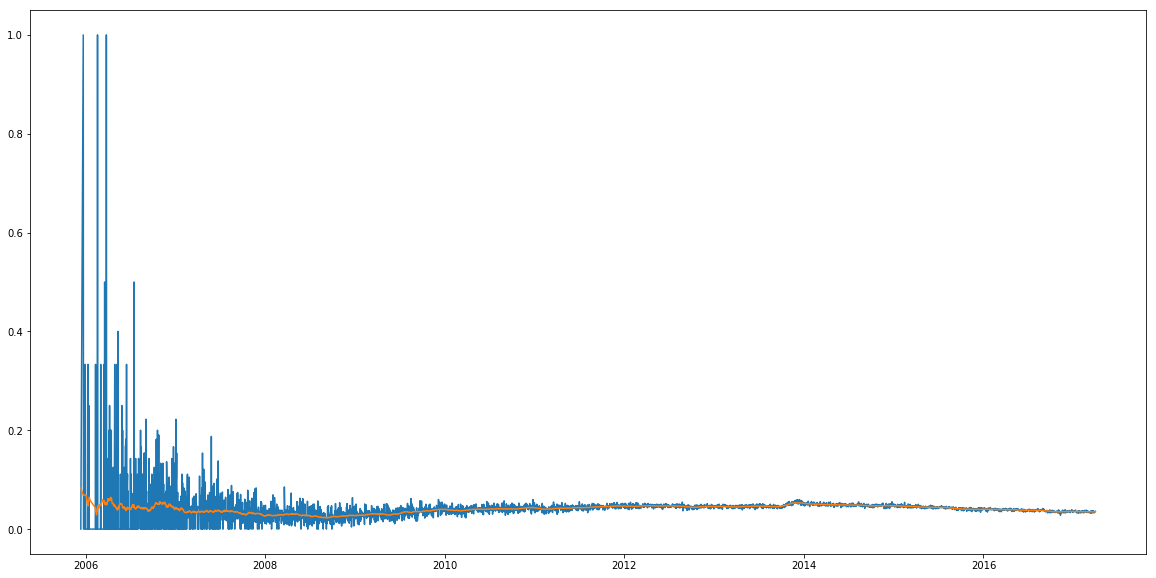

In [101]:
blob_plot_stat(subj=True, subj_avg=True)

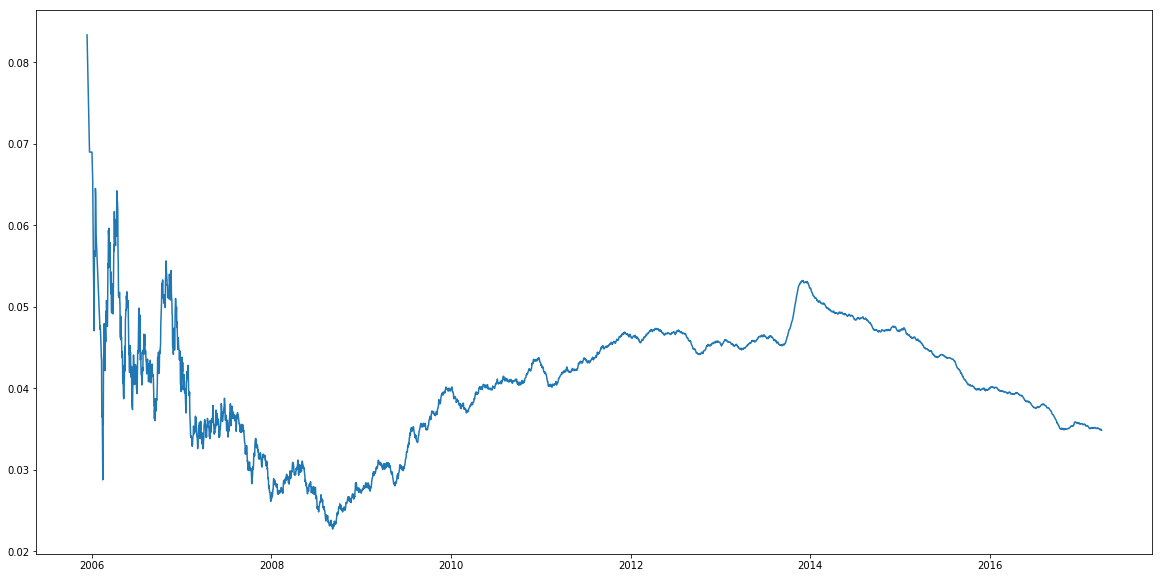

In [104]:
blob_plot_stat(subj_avg=True)

#### Blob 2015-2017

In [106]:
blob_plot_stat = plot_blob_metrics(blob_15_17_name, blob_sql_query, blob_sql_table_name)

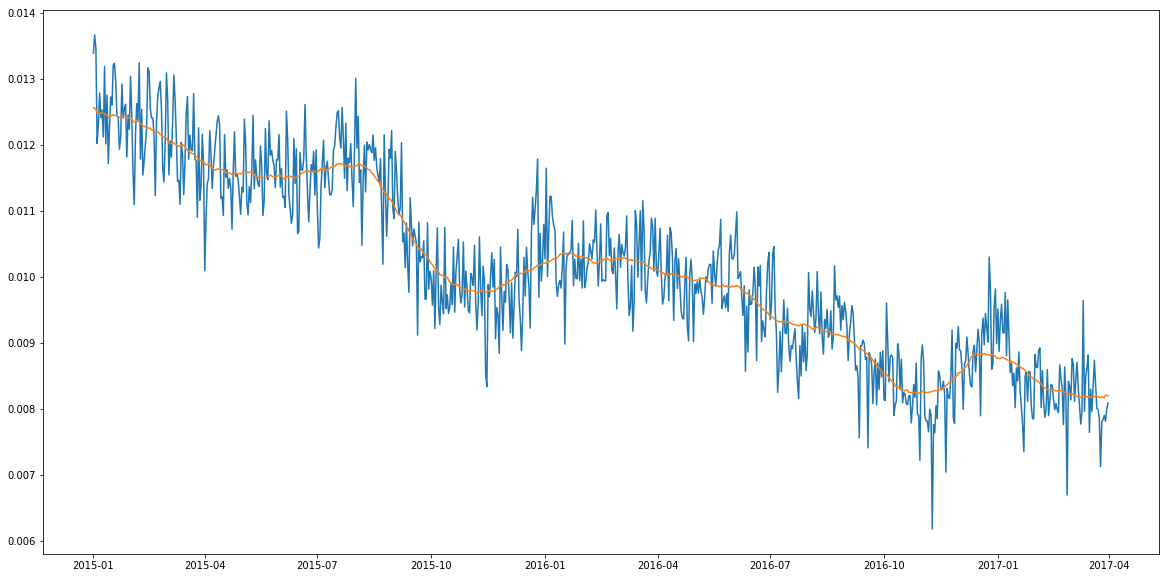

In [107]:
blob_plot_stat(pol=True, pol_avg=True)

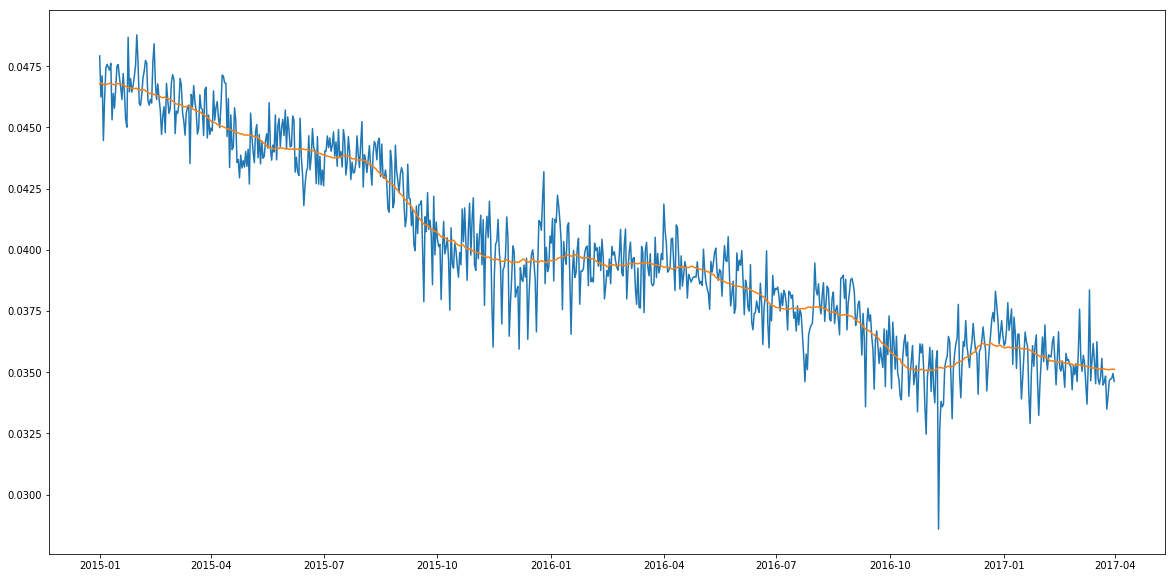

In [108]:
blob_plot_stat(subj=True, subj_avg=True)

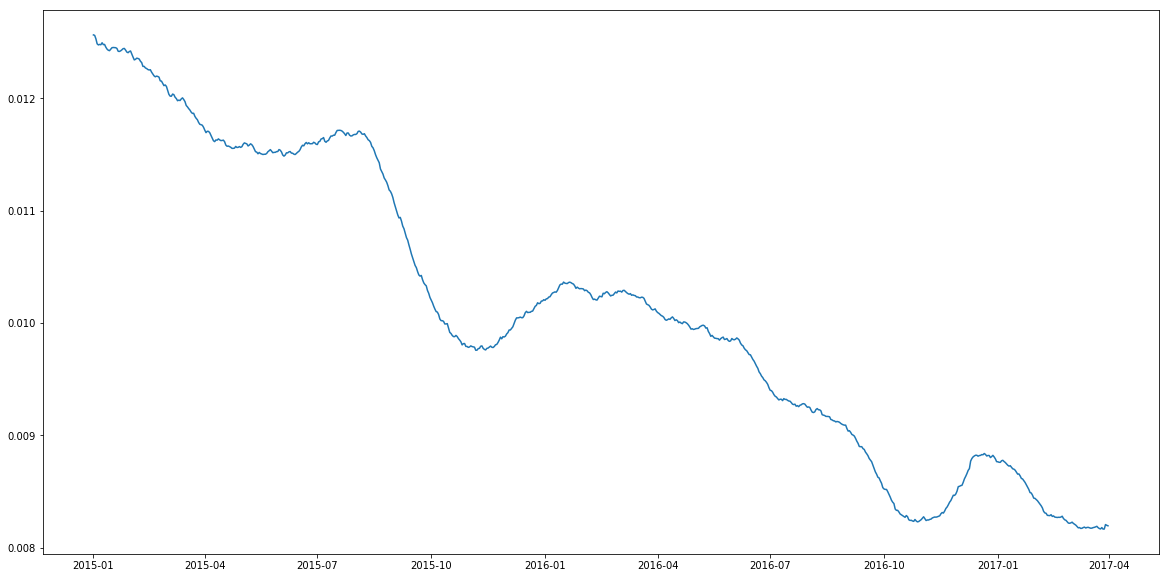

In [109]:
blob_plot_stat(pol_avg=True)

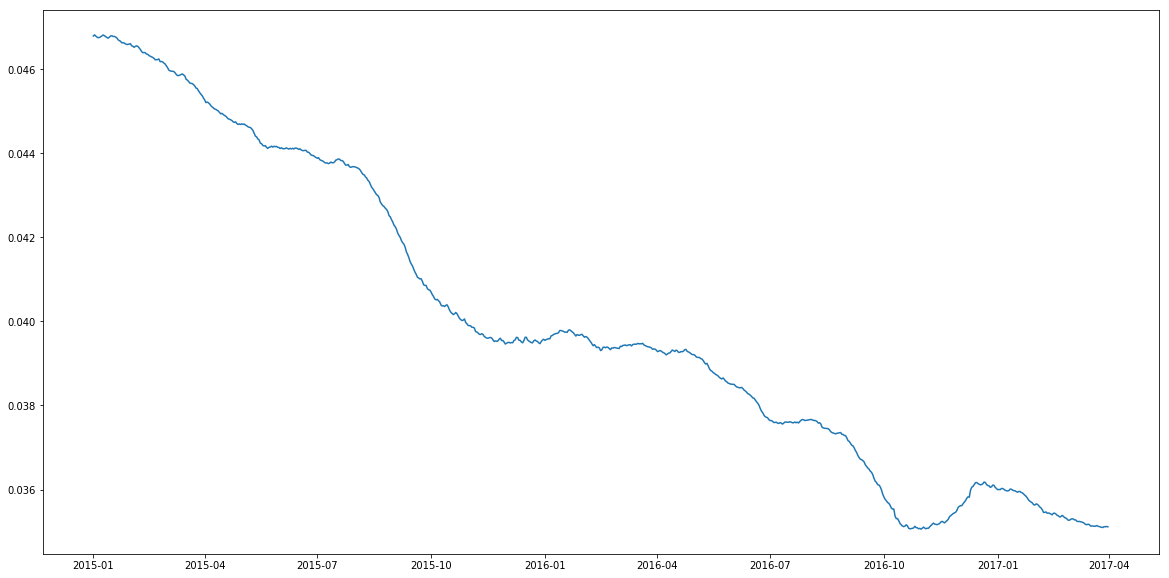

In [110]:
blob_plot_stat(subj_avg=True)

### Bad words metrics

In [7]:
bw_full_name = '../data/nlp_bw_metrics_daily_full_0.01.parquet/'
bw_15_17_name = '../data/nlp_bw_metrics_daily_15_17_0.1.parquet/'

bw_sql_table_name = 'bw_metrics'
bw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_bw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_bw_matches_60d_avg

FROM {bw_sql_table_name}
""")

def plot_bw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    # TODO: ADD LEGENDS
    def plot_stat(bw=False, bw_avg=False):
        if bw or bw_avg:
            plt.figure(figsize=(20, 10))
            if bw:
                plt.plot(m_n['sum_nb_bw_matches'])
            if bw_avg:
                plt.plot(m_avg_n['nb_bw_matches_60d_avg'])
        else:
            print('Please set one of the following parameter to True: [bw, bw_avg]')
            
    return plot_stat

#### Bad words 2005-2017

In [10]:
bw_plot_stat = plot_bw_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)

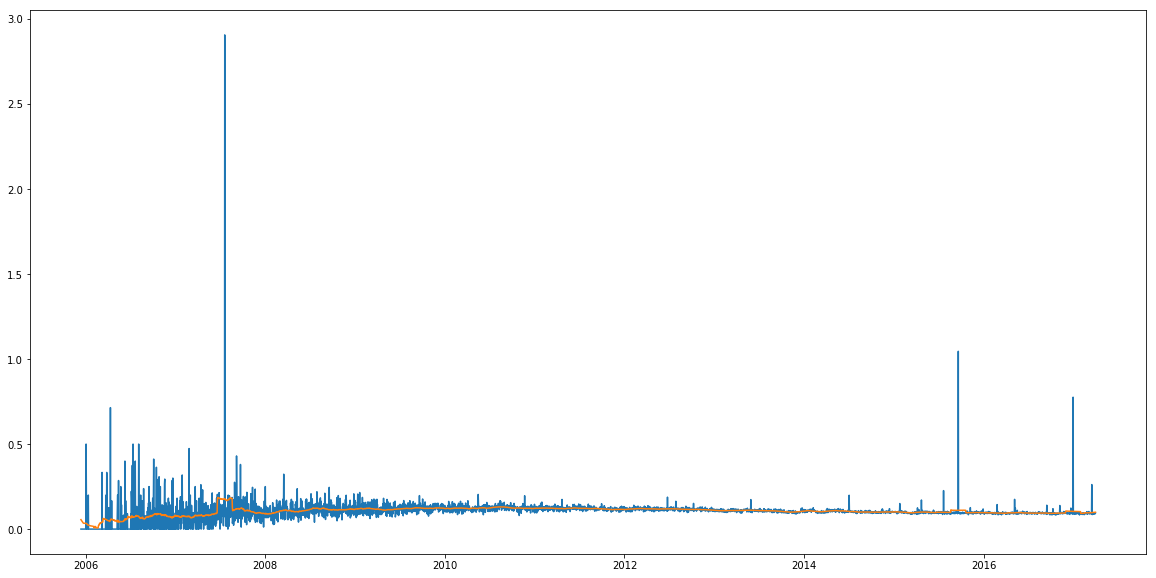

In [11]:
bw_plot_stat(bw=True, bw_avg=True)

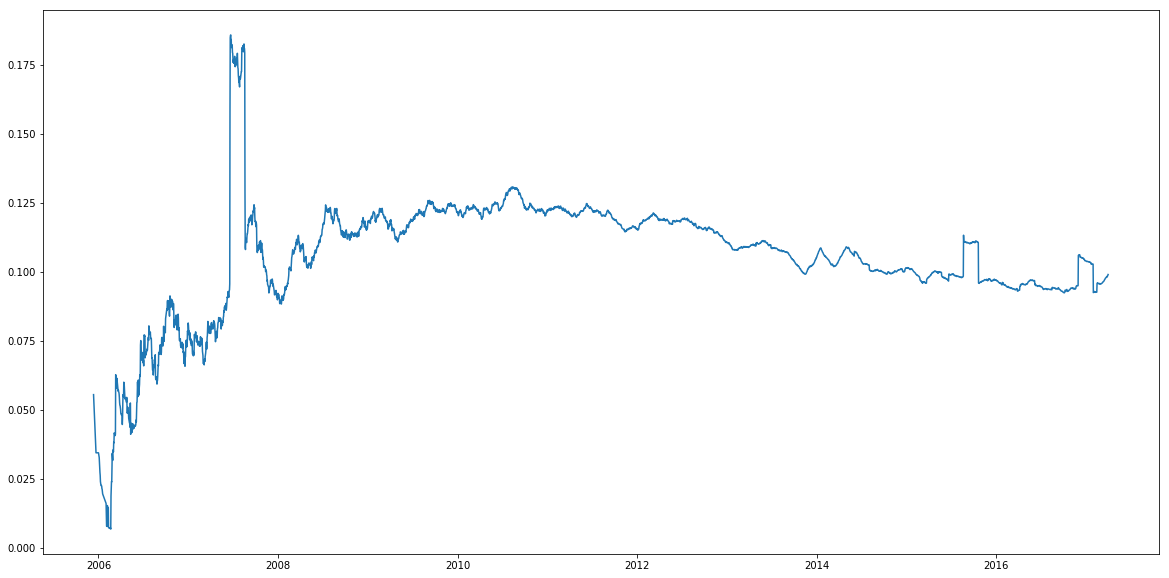

In [14]:
bw_plot_stat(bw_avg=True)

#### Bad words 2015-2017

In [15]:
bw_plot_stat = plot_bw_metrics(bw_15_17_name, bw_sql_query, bw_sql_table_name)

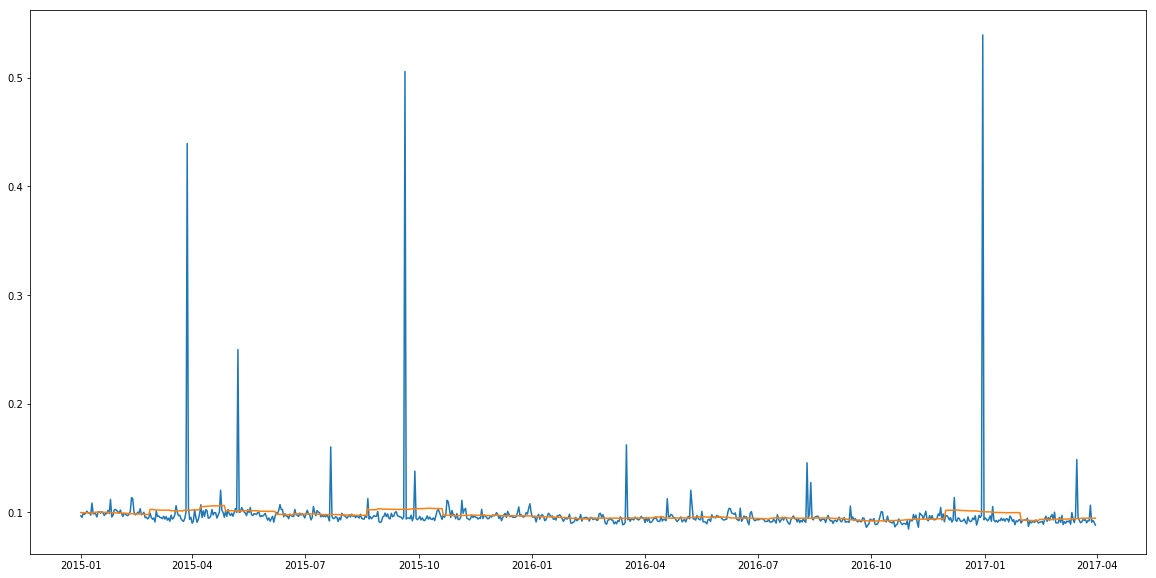

In [16]:
bw_plot_stat(bw=True, bw_avg=True)

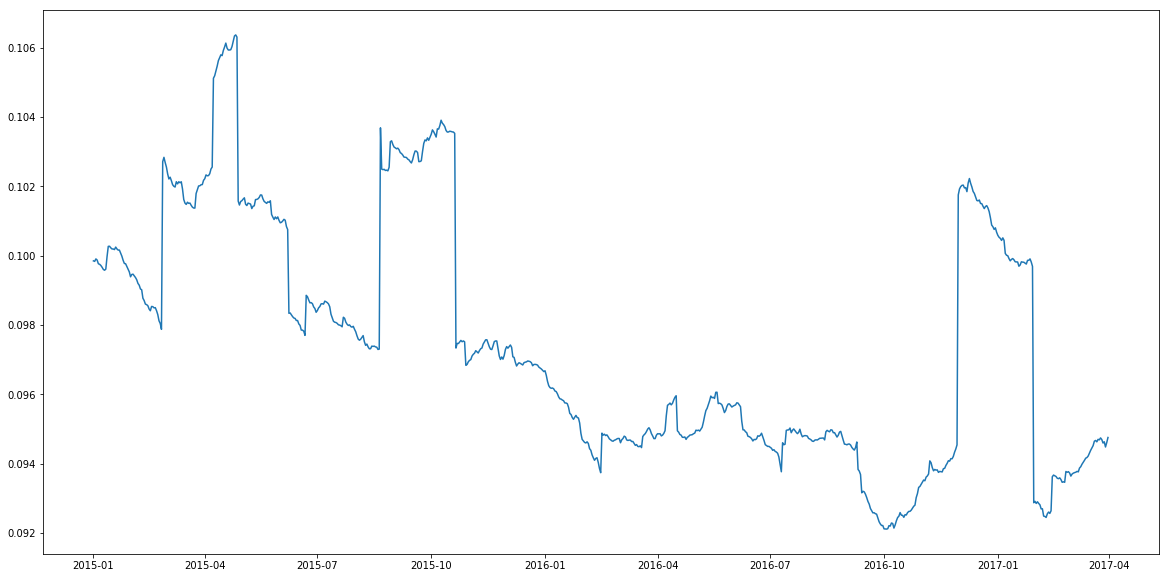

In [17]:
bw_plot_stat(bw_avg=True)

### Hate words metrics

In [8]:
hw_full_name = '../data/nlp_hw_metrics_daily_full_0.01.parquet/'
hw_15_17_name = '../data/nlp_hw_metrics_daily_15_17_0.1.parquet/'

hw_sql_table_name = 'hw_metrics'
hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,

    AVG(sum_nb_hw_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_matches_60d_avg

FROM {hw_sql_table_name}
""")

def plot_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    # TODO: ADD LEGENDS
    def plot_stat(hw=False, hw_avg=False):
        if hw or hw_avg:
            plt.figure(figsize=(20, 10))
            if hw:
                plt.plot(m_n['sum_nb_hw_matches'])
            if hw_avg:
                plt.plot(m_avg_n['nb_hw_matches_60d_avg'])
        else:
            print('Please set one of the following parameter to True: [hw, hw_avg]')
            
    return plot_stat

#### Hate words 2005-2017

In [28]:
hw_plot_stat = plot_hw_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)

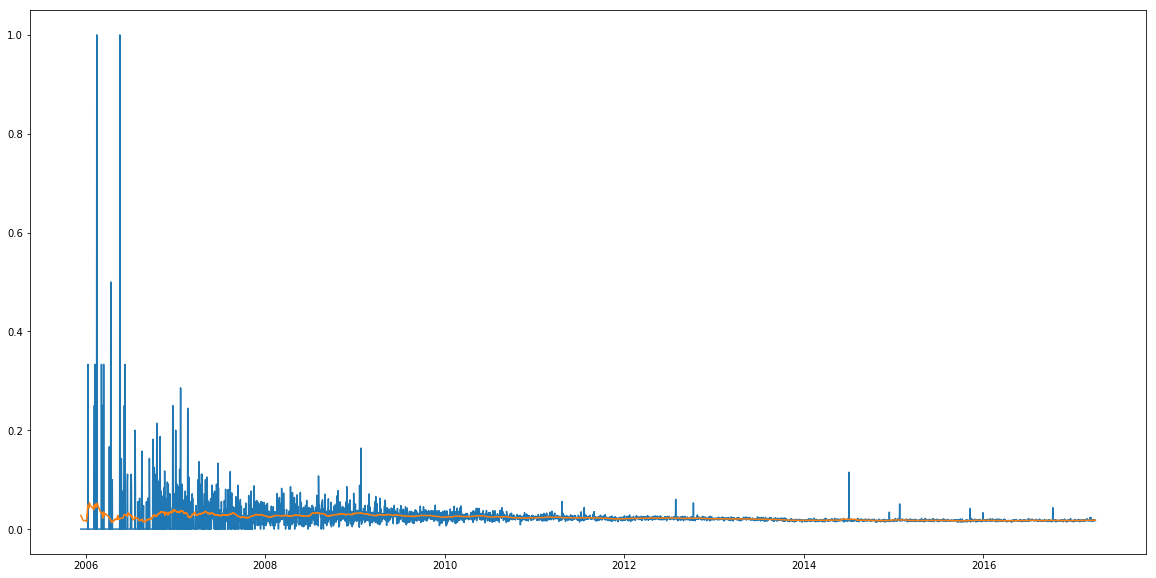

In [29]:
hw_plot_stat(hw=True, hw_avg=True)

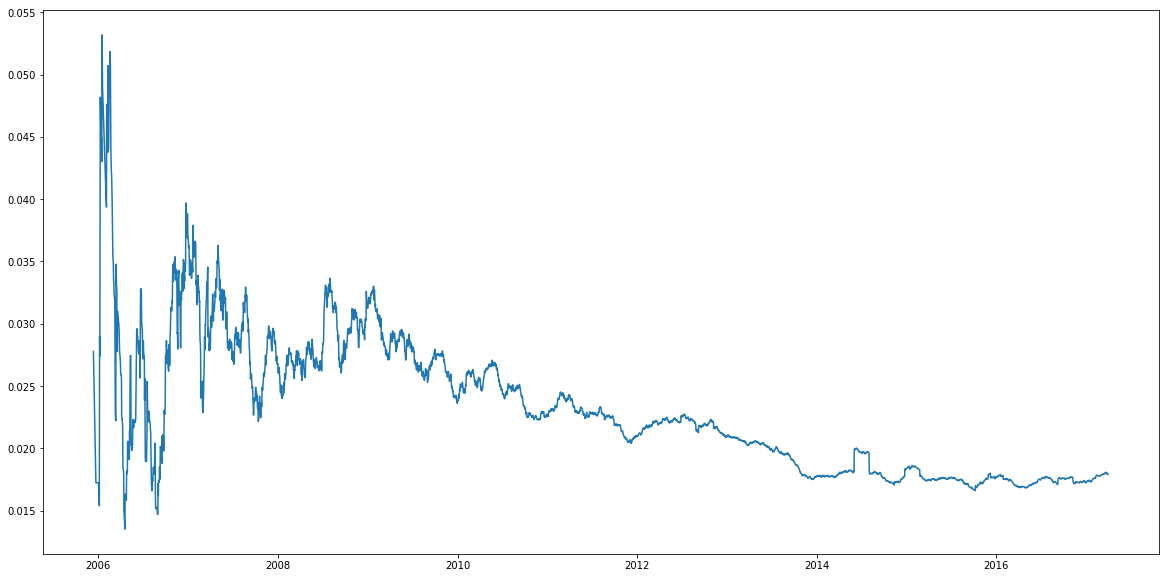

In [30]:
hw_plot_stat(hw_avg=True)

#### Hate words 2015-2017

In [32]:
hw_plot_stat = plot_hw_metrics(hw_15_17_name, hw_sql_query, hw_sql_table_name)

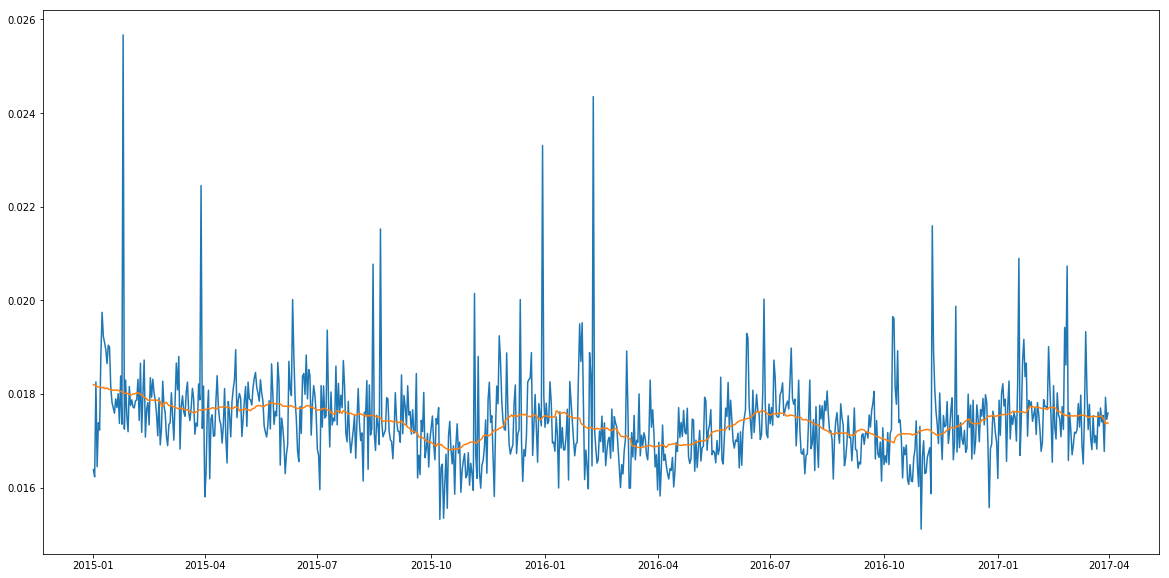

In [33]:
hw_plot_stat(hw=True, hw_avg=True)

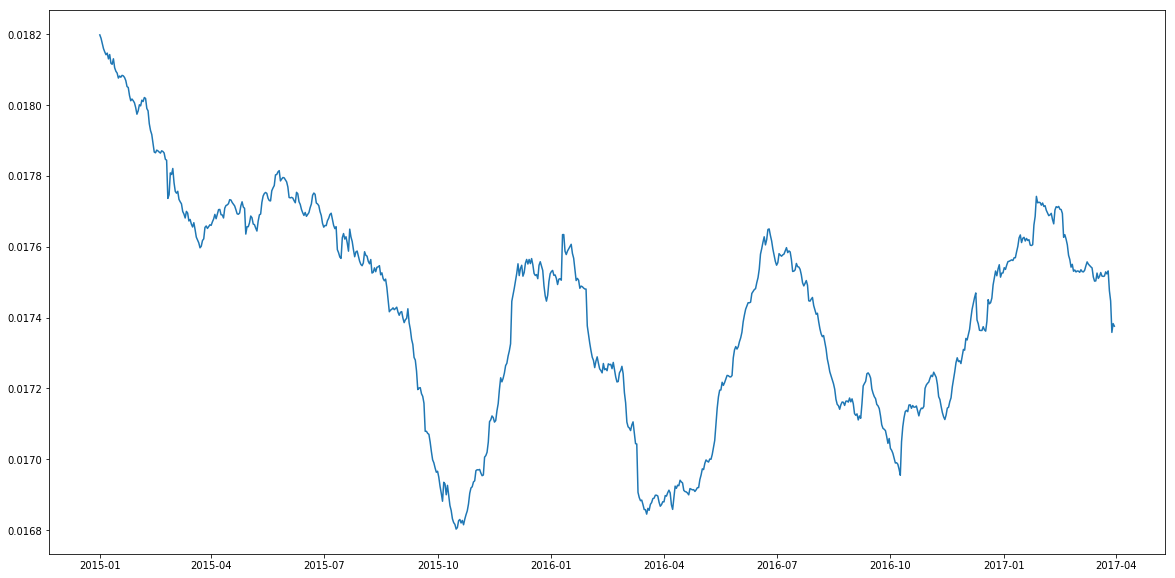

In [34]:
hw_plot_stat(hw_avg=True)

### Refined Hate Words

In [9]:
ref_hw_full_name = '../data/nlp_ref_hw_metrics_daily_full_0.01.parquet/'
ref_hw_15_17_name = '../data/nlp_ref_hw_metrics_daily_15_17_0.1.parquet/'

ref_hw_sql_table_name = 'ref_hw_metrics'
ref_hw_sql_query = (f"""
SELECT
    creation_date,
    
    AVG(msg_count) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS msg_count_60d_avg,
    
    AVG(sum_hw_ref_intensity) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS hw_ref_intensity_60d_avg,

    AVG(sum_nb_hw_ref_matches) OVER (
        ORDER BY creation_date
        RANGE BETWEEN 30 PRECEDING AND 30 FOLLOWING
    ) AS nb_hw_ref_matches_60d_avg

FROM {ref_hw_sql_table_name}
""")

def plot_ref_hw_metrics(filename, sql_query, sql_table_name):
    m_n, m_avg_n, m, m_avg = get_metrics(filename, sql_query, sql_table_name)
    
    # TODO: ADD LEGENDS
    def plot_stat(ref_hw=False, ref_hw_avg=False, intensity=False, intensity_avg=False):
        if ref_hw or ref_hw_avg or intensity or intensity_avg:
            plt.figure(figsize=(20, 10))
            if ref_hw:
                plt.plot(m_n['sum_nb_hw_ref_matches'])
            if ref_hw_avg:
                plt.plot(m_avg_n['nb_hw_ref_matches_60d_avg'])
            if intensity:
                plt.plot(m_n['sum_hw_ref_intensity'])
            if intensity_avg:
                plt.plot(m_avg_n['hw_ref_intensity_60d_avg'])
        else:
            print('Please set one of the following parameter to True: [ref_hw, ref_hw_avg, intensity, intensity_avg]')
            
    return plot_stat

In [46]:
ref_hw_plot_stat = plot_ref_hw_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)

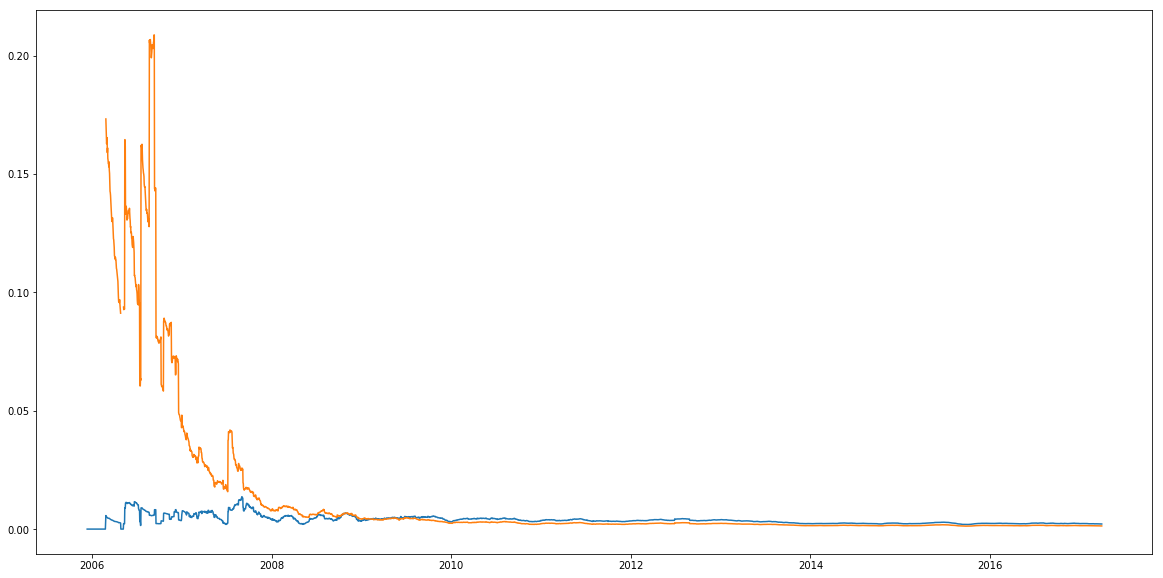

In [48]:
ref_hw_plot_stat(ref_hw_avg=True, intensity_avg=True)

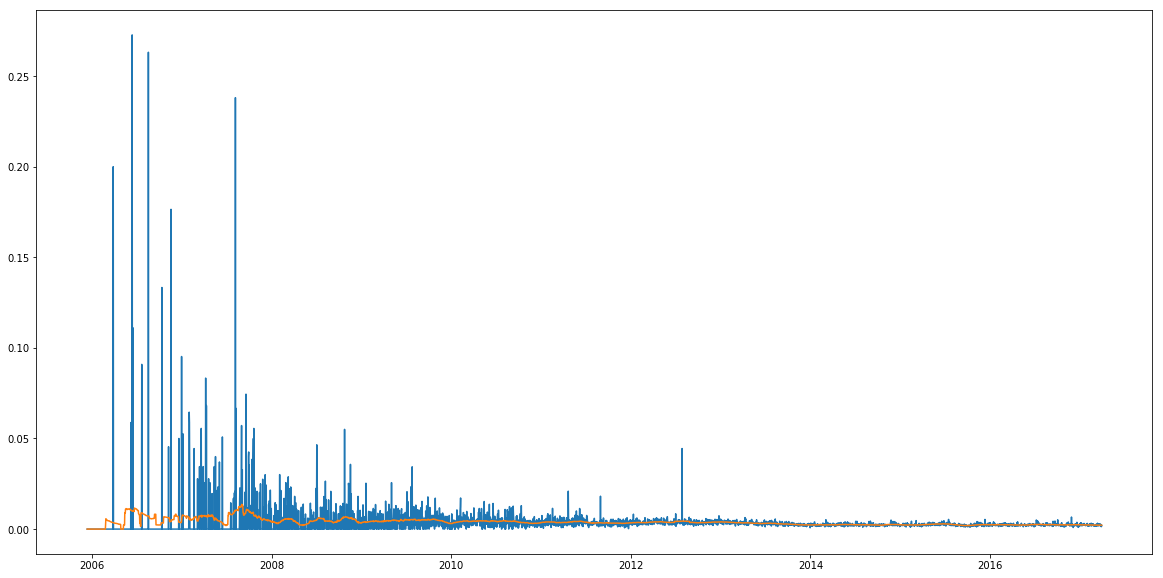

In [47]:
ref_hw_plot_stat(ref_hw=True, ref_hw_avg=True)

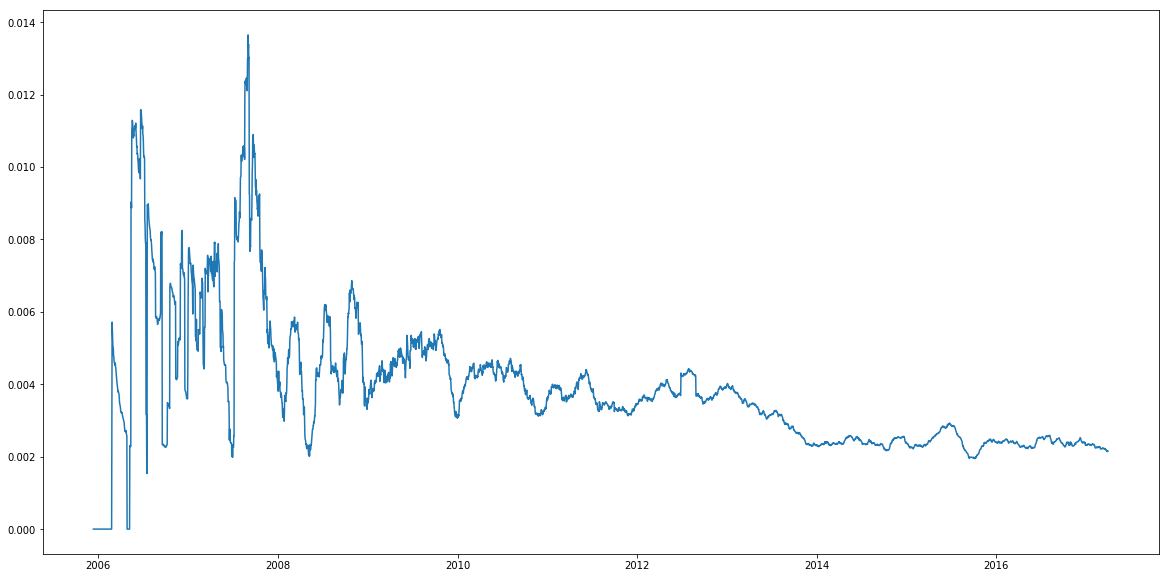

In [50]:
ref_hw_plot_stat(ref_hw_avg=True)

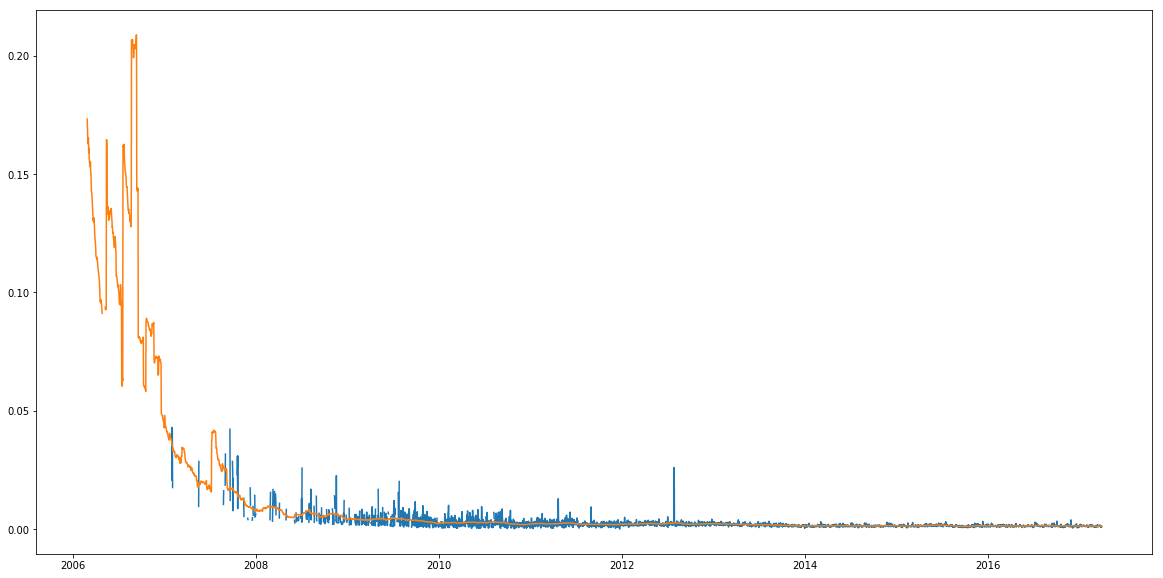

In [49]:
ref_hw_plot_stat(intensity=True, intensity_avg=True)

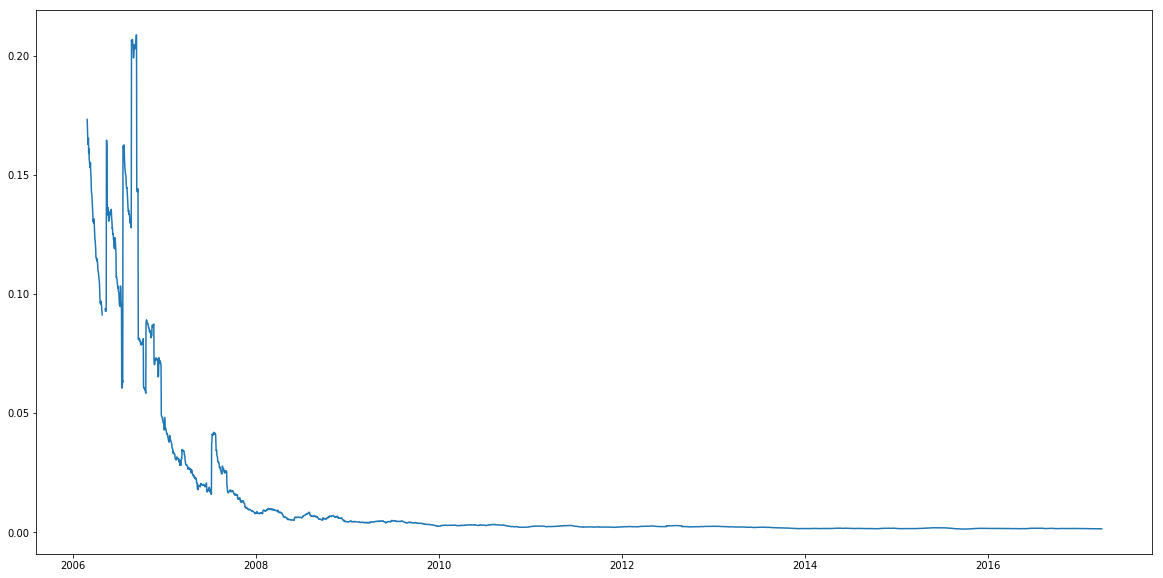

In [51]:
ref_hw_plot_stat(intensity_avg=True)

### Correlation analysis

In [10]:
nltk_n, nltk_avg_n, _, _ = get_metrics(nltk_full_name, nltk_sql_query, nltk_sql_table_name)
blob_n, blob_avg_n, _, _ = get_metrics(blob_full_name, blob_sql_query, blob_sql_table_name)
bw_n, bw_avg_n, _, _ = get_metrics(bw_full_name, bw_sql_query, bw_sql_table_name)
hw_n, hw_avg_n, _, _ = get_metrics(hw_full_name, hw_sql_query, hw_sql_table_name)
hw_ref_n, hw_ref_avg_n, _, _ = get_metrics(ref_hw_full_name, ref_hw_sql_query, ref_hw_sql_table_name)
nlp_n = pd.concat([nltk_n, blob_n, bw_n, hw_n, hw_ref_n], axis=1, sort=True).drop('msg_count', axis=1)

In [18]:
pd.to_pickle(nlp_n, '../data/daily_nlp_metrics_merged.pkl')

In [11]:
nlp_n.corr()

,sum_nltk_negativity,sum_nltk_neutrality,sum_nltk_positivity,sum_blob_polarity,sum_blob_subjectivity,sum_nb_bw_matches,sum_nb_hw_matches,sum_nb_hw_ref_matches,sum_hw_ref_intensity
sum_nltk_negativity,1.000000,-0.532513,-0.255297,-0.075377,-0.097588,0.068259,0.121264,0.037095,0.219414
sum_nltk_neutrality,-0.532513,1.000000,-0.677119,-0.117895,-0.124244,-0.052771,0.030276,0.018633,0.198851
sum_nltk_positivity,-0.255297,-0.677119,1.000000,0.202956,0.225370,0.001486,-0.142966,-0.051659,-0.301608
sum_blob_polarity,-0.075377,-0.117895,0.202956,1.000000,0.514469,-0.014896,-0.024457,0.027460,0.106186
sum_blob_subjectivity,-0.097588,-0.124244,0.225370,0.514469,1.000000,-0.044105,-0.069552,-0.001889,-0.030310
sum_nb_bw_matches,0.068259,-0.052771,0.001486,-0.014896,-0.044105,1.000000,0.028075,0.027948,0.018229
sum_nb_hw_matches,0.121264,0.030276,-0.142966,-0.024457,-0.069552,0.028075,1.000000,0.067966,0.311492
sum_nb_hw_ref_matches,0.037095,0.018633,-0.051659,0.027460,-0.001889,0.027948,0.067966,1.000000,0.996249
sum_hw_ref_intensity,0.219414,0.198851,-0.301608,0.106186,-0.030310,0.018229,0.311492,0.996249,1.000000


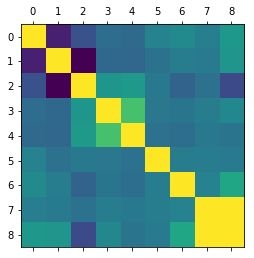

In [12]:
plt.matshow(nlp_n.corr())

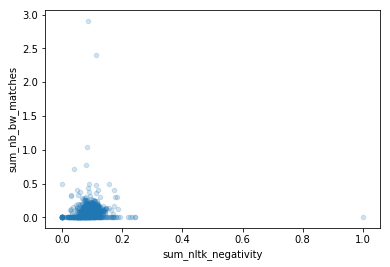

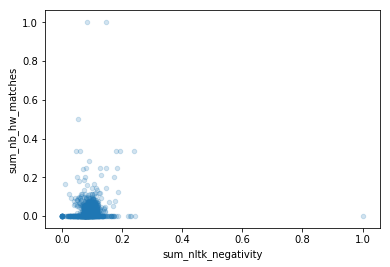

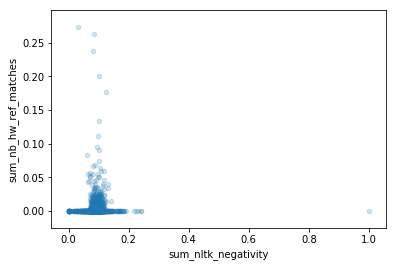

In [13]:
nlp_n.plot.scatter('sum_nltk_negativity', 'sum_nb_bw_matches', alpha=0.2)
nlp_n.plot.scatter('sum_nltk_negativity', 'sum_nb_hw_matches', alpha=0.2)
nlp_n.plot.scatter('sum_nltk_negativity', 'sum_nb_hw_ref_matches', alpha=0.2)

In [14]:
nltk_n.drop('msg_count', axis=1).corr()

,sum_nltk_negativity,sum_nltk_neutrality,sum_nltk_positivity
sum_nltk_negativity,1.000000,-0.532513,-0.255297
sum_nltk_neutrality,-0.532513,1.000000,-0.677119
sum_nltk_positivity,-0.255297,-0.677119,1.000000


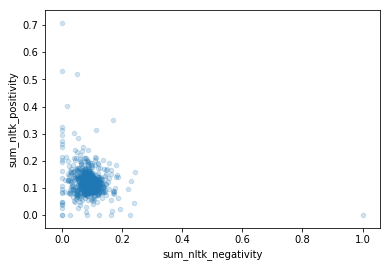

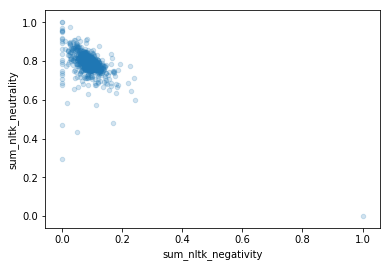

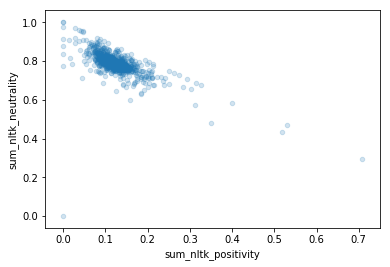

In [15]:
nltk_n.plot.scatter('sum_nltk_negativity', 'sum_nltk_positivity', alpha=0.2)
nltk_n.plot.scatter('sum_nltk_negativity', 'sum_nltk_neutrality', alpha=0.2)
nltk_n.plot.scatter('sum_nltk_positivity', 'sum_nltk_neutrality', alpha=0.2)

In [16]:
blob_n.drop('msg_count', axis=1).corr()

,sum_blob_polarity,sum_blob_subjectivity
sum_blob_polarity,1.000000,0.514469
sum_blob_subjectivity,0.514469,1.000000


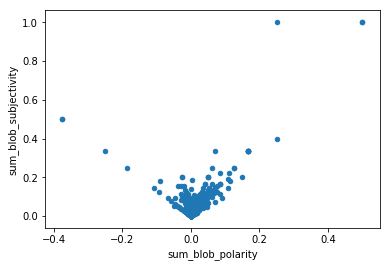

In [17]:
blob_n.plot.scatter('sum_blob_polarity', 'sum_blob_subjectivity')